## Import Dependencies

In [1]:
# Import system libs
import os
import time
import shutil
import pathlib
import itertools
import glob

# Import data handling tools
import cv2
import zipfile
import gdown
import numpy as np
import pandas as pd
from collections import Counter
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image



# Import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import layers,regularizers

# Import pretrained models
from tensorflow.keras.applications import (
    resnet50,
    efficientnet_v2,
    mobilenet_v3,
    densenet,
    xception
)


# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")


## Check for GPU

In [2]:
# Checking For GPU
gpus = tf.config.list_physical_devices('GPU')

print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 Running on GPU' if gpus else '\t\u2022 GPU device not found. Running on CPU')
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Using:
	• TensorFlow version: 2.18.0
	• Running on GPU


## Mount Dataset from GDrive

In [3]:
file_id = '1E1MJz86go08H9rtRCOY2A84rldCXkbww'
url = f'https://drive.google.com/uc?id={file_id}'

# Download the file
gdown.download(url, 'brain-tumor-ds.zip', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1E1MJz86go08H9rtRCOY2A84rldCXkbww
From (redirected): https://drive.google.com/uc?id=1E1MJz86go08H9rtRCOY2A84rldCXkbww&confirm=t&uuid=6a179718-5fc2-4165-a0d1-54d49a372b12
To: /content/brain-tumor-ds.zip
100%|██████████| 197M/197M [00:04<00:00, 42.0MB/s]


'brain-tumor-ds.zip'

## Extract ZIP Dataset

In [4]:
def extract_dataset():
  # Path to the zip file in Google Drive
  zip_path = 'brain-tumor-ds.zip'

  # Path to extract the dataset inside Colab environment
  extract_path = 'brain-tumor-dataset'

  # Unzip the dataset only if not already extracted
  if not os.path.exists(extract_path):
      with zipfile.ZipFile(zip_path, 'r') as zip_ref:
          zip_ref.extractall(extract_path)
      print("Dataset extracted.")
  else:
      print("Dataset already extracted.")

  return None


## Data Collection

In [5]:
# Step 1: Gather all image paths and labels (supports .jpg, .jpeg, .png)
def load_dataset(DATA_DIR):
  image_paths = []
  labels = []

  supported_extensions = ('*.jpg', '*.jpeg', '*.png')

  for class_name in sorted(os.listdir(DATA_DIR)):
      class_dir = os.path.join(DATA_DIR, class_name)
      if not os.path.isdir(class_dir):
          continue

      for ext in supported_extensions:
          for img_file in glob.glob(os.path.join(class_dir, ext)):
              image_paths.append(img_file)
              labels.append(class_name)
  print(f"Total images: {len(image_paths)}")
  # Get Labels
  unique_labels = sorted(set(labels))
  # Ensure number of classes
  number_of_classes = len(unique_labels)

  return image_paths,labels,number_of_classes


## Data Preprocessing

In [6]:
# Step 2: Encode class names as integers
def encode_class_names(labels):

  label_encoder = LabelEncoder()
  encoded_labels = label_encoder.fit_transform(labels)
  num_classes = len(label_encoder.classes_)
  class_names = label_encoder.classes_
  print("Total Number of unique labels (classes) : ",number_of_classes)
  print(f"Class Names : ",class_names)
  return encoded_labels,class_names

## Stratified Data Split

In [7]:
# Step 3: Stratified split -> train (70%), val (15%), test (15%)
def split_data(image_paths, encoded_labels, SEED=42):
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, encoded_labels, test_size=0.15, stratify=encoded_labels, random_state=SEED
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=SEED
    )
    # 0.1765 × 0.85 ≈ 0.15 => val = 15%

    total = len(image_paths)
    print(f"Train: {len(X_train)} ({len(X_train)/total:.2%}), "
          f"Val: {len(X_val)} ({len(X_val)/total:.2%}), "
          f"Test: {len(X_test)} ({len(X_test)/total:.2%})")
    return X_train, y_train, X_val, y_val, X_test, y_test


## Data Augmentation

In [8]:
# Define Data Augmentation Pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")


## Image Preprocessing

In [9]:
# Step 4: Create TensorFlow dataset from paths and labels
def preprocess_image(file_path, label, num_classes, IMG_SIZE=224, preprocess_fn=None):
    """
    General preprocessing function with model-specific preprocessing (if provided)
    and one-hot encoding.
    """
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)

    if preprocess_fn is not None:
        image = preprocess_fn(image)
    else:
        image = image / 255.0

    label = tf.one_hot(label, depth=num_classes)
    return image, label


def augment_image(image, label):
    image = data_augmentation(image)
    return image, label



## Prepare Dataset

In [10]:
def prepare_dataset(paths, labels, num_classes, preprocess_fn=None,
                    shuffle=True, augment=False, BATCH_SIZE=32, IMG_SIZE=224, SEED=42):
    """
    Create a TensorFlow Dataset pipeline with preprocessing, optional augmentation, batching and prefetching.

    Args:
        paths (list): List of image file paths.
        labels (list/array): Corresponding labels.
        num_classes (int): Total number of classes (for one-hot encoding).
        preprocess_fn (function): Preprocessing function specific to the pretrained model.
        shuffle (bool): Whether to shuffle the dataset.
        augment (bool): Whether to apply data augmentation.
        BATCH_SIZE (int): Batch size.
        IMG_SIZE (int): Image size for resizing.
        SEED (int): Random seed for reproducibility.

    Returns:
        tf.data.Dataset: Prepared dataset.
    """

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)

    # Step 1: Apply preprocessing
    ds = ds.map(
        lambda path, label: preprocess_image(path, label, num_classes, IMG_SIZE, preprocess_fn),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Step 2: Optional data augmentation
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Step 3: Batch and prefetch
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return ds


## Constructing Preprocessing Pipeline

In [11]:
def construct_pipeline(X_train, y_train, X_val, y_val, X_test, y_test, num_classes,preprocess_fn, IMG_SIZE=224, BATCH_SIZE=32):
    """
    Prepares TensorFlow Datasets for training, validation, and testing.

    Args:
        X_train, y_train: Training image paths and labels
        X_val, y_val: Validation image paths and labels
        X_test, y_test: Testing image paths and labels
        num_classes: Number of classes for one-hot encoding
        preprocessing_method : Preprocessing function for images
        IMG_SIZE: Tuple (height, width) for resizing images
        BATCH_SIZE: Batch size for training

    Returns:
        A tuple of (train_ds, val_ds, test_ds) TensorFlow datasets
    """

    train_ds = prepare_dataset(X_train, y_train, num_classes,preprocess_fn=preprocess_fn, shuffle=True, augment=True,
                               BATCH_SIZE=BATCH_SIZE, IMG_SIZE=IMG_SIZE)
    val_ds   = prepare_dataset(X_val, y_val, num_classes,preprocess_fn=preprocess_fn, shuffle=False, augment=False,
                               BATCH_SIZE=BATCH_SIZE, IMG_SIZE=IMG_SIZE)
    test_ds  = prepare_dataset(X_test, y_test, num_classes,preprocess_fn=preprocess_fn, shuffle=False, augment=False,
                               BATCH_SIZE=BATCH_SIZE, IMG_SIZE=IMG_SIZE)

    return train_ds, val_ds, test_ds


## Data Exploration

In [12]:
def analyze_data_split(y_train, y_val, y_test, original_labels, class_names):
    def get_distribution(y, subset_name):
        count_dict = Counter(y)
        dist_df = pd.DataFrame({
            "Class Index": list(count_dict.keys()),
            "Class Name": [class_names[i] for i in count_dict.keys()],
            "Count": list(count_dict.values())
        })

        dist_df["Percentage"] = dist_df["Count"] / len(y) * 100
        dist_df = dist_df.sort_values("Class Name").reset_index(drop=True)

        plt.figure(figsize=(14, 5))
        ax = sns.barplot(data=dist_df, x="Class Name", y="Percentage", palette="viridis")


        for i in ax.containers:
            ax.bar_label(i, fmt='%.1f%%', label_type='edge', fontsize=9, padding=3)

        plt.title(f"{subset_name} Set Class Distribution (%)")
        plt.xticks(rotation=90)
        plt.ylabel("Percentage")
        plt.xlabel("Class")
        plt.tight_layout()
        plt.show()

    get_distribution(y_train, "Train")
    get_distribution(y_val, "Validation")
    get_distribution(y_test, "Test")


## Visualize Samples

In [13]:
def samples_visualization(dataset, class_names, num_samples=5):
    """
    Visualize a few samples from a tf.data.Dataset

    Args:
        dataset (tf.data.Dataset): The dataset to visualize from (batched).
        class_names (list): List of class names in order.
        num_samples (int): Number of samples to show.
    """
    count = 0
    for batch_images, batch_labels in dataset:
        for img, label in zip(batch_images, batch_labels):
            if count >= num_samples:
                return

            # Convert tensor to numpy
            img_np = img.numpy()
            label_np = label.numpy()

            # Decode one-hot to class name
            class_index = int(np.argmax(label_np))
            class_name = class_names[class_index]

            # Print shape and plot image
            print(f"Image #{count + 1} — shape: {img_np.shape}, class: {class_name}")
            plt.imshow(img_np)
            plt.title(class_name)
            plt.axis('off')
            plt.show()

            count += 1


## Build Model

In [14]:
def build_transfer_model(input_shape, n_classes, pretrained_model=tf.keras.applications.EfficientNetV2B0):
    """
    Build a model based on pretrained model architecture.
    Initially freezes pretrained layers.

    Returns:
        (model, base_model): full model and the base pretrained part
    """
    initializer = tf.keras.initializers.GlorotNormal(42)

    base_model = pretrained_model(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )



    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x) 

    x = tf.keras.layers.Dense(
        512,
        activation='relu',
        kernel_initializer=initializer,
        kernel_regularizer=regularizers.l2(0.01)
    )(x)


    x = tf.keras.layers.Dense(
        256,
        activation='relu',
        kernel_initializer=initializer,
        kernel_regularizer=regularizers.l2(0.005)
    )(x)



    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(
        n_classes,
        activation='softmax',
        kernel_initializer=initializer,
        kernel_regularizer=regularizers.l2(0.0005)
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)



    print(f"Total layers in model: {len(model.layers)}")
    print(f"Base model trainable: {base_model.trainable}")
    print(f"Trainable weights: {len(model.trainable_weights)}")
    print(f"Non-trainable weights: {len(model.non_trainable_weights)}")

    return model, base_model


## Compile and Train Model

In [15]:
def compile_and_train_model(model, train_batches, val_batches, epochs=1, lr=0.1, patience=10):
    """
    Compile and train the model with initially frozen layers.

    Args:
        model: Keras model to train
        train_batches: training dataset
        val_batches: validation dataset
        epochs: Number of epochs
        lr: Initial learning rate
        patience: Early stopping patience

    Returns:
        Training history
    """
    print("\n--- Phase 1: Training with frozen base model ---")
    print(f"Using learning rate: {lr}")

    # Optimizer
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

    # Compile model (assuming one-hot labels)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    # Visualize model structure
    tf.keras.utils.plot_model(model, show_shapes=True)
    model.summary()

    # Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience,min_delta=0.1   , restore_best_weights=True)

    history = model.fit(
        train_batches,
        validation_data=val_batches,
        epochs=epochs,
        callbacks=[early_stop],
    )

    return history


## Fine-Tune By Layers

In [16]:
def fine_tune_model_by_layers(model, base_model, train_batches, val_batches,
                               unfreeze_from_layer=100, lr=1e-4, epochs=5):
    """
    Unfreeze layers from the given index in the base model and fine-tune.

    Args:
        model: Full model containing base_model + custom head
        base_model: Pretrained base model
        train_batches: training dataset
        val_batches : validation dataset
        unfreeze_from_layer: Index in base_model to start unfreezing
        lr: Learning rate
        epochs: Fine-tuning epochs

    Returns:
        training history
    """
    print("\n--- Phase 2: Fine-tuning from layer", unfreeze_from_layer, "---")

    # Unfreeze the desired layers in the base model
    base_model.trainable = True
    for i, layer in enumerate(base_model.layers):
        layer.trainable = i >= unfreeze_from_layer

    # Recompile model
    model.compile(
        #optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Summary and trainable stats
    print("\n Model Summary:")
    model.summary()

    trainable_layers = [layer.name for layer in model.layers if layer.trainable]
    non_trainable_layers = [layer.name for layer in model.layers if not layer.trainable]

    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])


    total_layers = len(base_model.layers)
    trainable_layers = sum([layer.trainable for layer in base_model.layers])
    non_trainable_layers = total_layers - trainable_layers

    print("\n--- Base Model Layers Summary ---")
    print(f"Total layers in base_model       : {total_layers}")
    print(f"Trainable layers in base_model   : {trainable_layers}")
    print(f"Non-trainable layers in base_model: {non_trainable_layers}")

    print(f"\n---  Parameters Summary ---")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")
    print(f"Total parameters: {trainable_params + non_trainable_params:,}")

    # Train
    history = model.fit(
        train_batches,
        validation_data=val_batches,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                patience=10, min_delta=0.005, restore_best_weights=True
            )
        ]
    )

    return history


## Get Number of Layers

In [17]:
def get_num_layers(pretrained_model_class, input_shape=(224, 224, 3)):
    """
    Returns the number of layers in the base pretrained model.

    Args:
        pretrained_model_class: e.g., tf.keras.applications.EfficientNetB0
        input_shape: tuple, shape of the input image (default 224x224x3)

    Returns:
        int: number of layers in the model
    """
    # Build the model without the classification head
    pretrained_model = pretrained_model_class(weights="imagenet", include_top=False, input_shape=input_shape)

    return len(pretrained_model.layers)

## Data Postprocessing

In [18]:
def postprocess_image(image, preprocessing_type):
    """
    Undo model-specific preprocessing to get image back to uint8 [0-255] format.

    Args:
        image: preprocessed image tensor/array (usually float32)
        preprocessing_type: string specifying the model preprocessing applied

    Returns:
        image as uint8 numpy array scaled to [0,255]
    """
    if preprocessing_type == 'resnet50':
        # ResNet50 preprocess_input subtracts mean and converts RGB->BGR
        image = image + [103.939, 116.779, 123.68]  # Add means back
        image = image[..., ::-1]  # BGR to RGB
        image = np.clip(image, 0, 255)

    elif preprocessing_type == 'mobilenetv3':
        # MobileNet scales inputs to [-1, 1]
        image = (image + 1.0) * 127.5
        image = np.clip(image, 0, 255)

    elif preprocessing_type == 'efficientnetv2':
        # EfficientNet preprocess_input scales inputs to [0,1], so multiply back to [0,255]
        image = np.clip(image, 0, 255)

    elif preprocessing_type == 'densenet121':
        # DenseNet preprocess_input subtracts ImageNet mean RGB, does NOT change channel order
        # Mean values for ImageNet RGB: [103.94, 116.78, 123.68]
        image = image + [103.94, 116.78, 123.68]  # Add means back
        image = np.clip(image, 0, 255)

    elif preprocessing_type == 'xception':
        # Xception preprocess_input scales inputs to [-1, 1]
        # To reverse: scale from [-1,1] back to [0,255]
        image = (image + 1.0) * 127.5
        image = np.clip(image, 0, 255)

    else:
        # Default: assume images were scaled [0,1]
        image = image * 255.0
        image = np.clip(image, 0, 255)

    return image.astype(np.uint8)


## Model Evaluation

In [19]:
def evaluate_model(model, test_batches, class_names, preprocessing_type):
    """
    Evaluate the trained model on the test dataset and visualize predictions.

    Args:
        model: Trained Keras model
        test_batches: tf.data.Dataset of test data
        class_names: List of class names
        preprocessing_type: Type of preprocessing used ('resnet50', 'xception', 'mobilenet', etc.)

    Returns:
        Tuple of (loss, accuracy)
    """
    print("\n--- Evaluating model on test set ---")

    # Evaluate directly on the dataset
    loss, accuracy = model.evaluate(test_batches, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2%}")

    # Collect all test images and labels
    test_images = []
    test_labels = []

    for images, labels in test_batches:
        test_images.append(images.numpy())
        # If labels are one-hot, convert to class indices
        if len(labels.shape) > 1 and labels.shape[1] > 1:
            test_labels.append(np.argmax(labels.numpy(), axis=1))
        else:
            test_labels.append(labels.numpy())

    test_images = np.concatenate(test_images, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Get predictions
    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions, axis=1)

    # Classification report
    print("\nClassification Report:")
    class_report = classification_report(test_labels, pred_classes, target_names=class_names)
    print(class_report)

    # Show example predictions
    plt.figure(figsize=(15, 15))
    n_examples = min(9, len(test_images))

    for i in range(n_examples):
        plt.subplot(3, 3, i + 1)
        img = test_images[i].copy()

        # Reverse preprocessing
        img = postprocess_image(img, preprocessing_type)

        plt.imshow(img)
        color = 'green' if test_labels[i] == pred_classes[i] else 'red'
        plt.title(f"True: {class_names[test_labels[i]]}\nPred: {class_names[pred_classes[i]]}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(test_labels, pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return loss, accuracy,class_report


## Plot Learning Curves

In [20]:
def plot_learning_curves(history1, history2):
    """
    Plot learning curves from both training phases.

    Args:
        history1: History from initial training
        history2: History from fine-tuning
    """
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Training (Phase 1)')
    plt.plot(history1.history['val_accuracy'], label='Validation (Phase 1)')

    # Adjust for phase 2 (continue the graph)
    offset = len(history1.history['accuracy'])
    plt.plot(np.arange(offset, offset + len(history2.history['accuracy'])),
             history2.history['accuracy'], label='Training (Phase 2)')
    plt.plot(np.arange(offset, offset + len(history2.history['val_accuracy'])),
             history2.history['val_accuracy'], label='Validation (Phase 2)')

    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Training (Phase 1)')
    plt.plot(history1.history['val_loss'], label='Validation (Phase 1)')

    # Adjust for phase 2
    plt.plot(np.arange(offset, offset + len(history2.history['loss'])),
             history2.history['loss'], label='Training (Phase 2)')
    plt.plot(np.arange(offset, offset + len(history2.history['val_loss'])),
             history2.history['val_loss'], label='Validation (Phase 2)')

    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Main

In [27]:
# Define constants
DATA_DIR = '/content/brain-tumor-dataset'
IMG_SIZE =(224,224)
BATCH_SIZE = 32
SEED = 42


# Set random seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Declaring Pretrained models with their preprocessing functions

models = {
    "resnet50": (resnet50.preprocess_input, tf.keras.applications.ResNet50),
    "efficientnetv2": (efficientnet_v2.preprocess_input, tf.keras.applications.EfficientNetV2B0),
    "mobilenetv3": (mobilenet_v3.preprocess_input, tf.keras.applications.MobileNetV3Small),
    "densenet121": (densenet.preprocess_input, tf.keras.applications.DenseNet121),
    "xception": (xception.preprocess_input, tf.keras.applications.Xception),
    "inceptionv3":(tf.keras.applications.inception_v3.preprocess_input,tf.keras.applications.InceptionV3)
}


model_key = 'efficientnetv2'
selected_model = models[model_key]

# Declaring Hyperparameters

LR = 2e-3
EPOCHS = 100
LAYER_INDEX = 100
# ===== Pretrained Models Layers =====

# ResNet50 :  175
# EfficientNetV2B0 :  270
# MobileNetV3Small :  157
# DenseNet121 :  427
# Xception :  132
# InceptionV3 : 311

In [22]:

# Data Collection
extract_dataset()
image_paths,labels,number_of_classes = load_dataset(DATA_DIR)
# Data Preprocessing
encoded_labels,class_names = encode_class_names(labels)
X_train ,y_train,X_val,y_val,X_test,y_test = split_data(image_paths,encoded_labels)
train_ds, val_ds, test_ds = construct_pipeline(X_train ,y_train,X_val,y_val,X_test,y_test,num_classes=44,preprocess_fn = selected_model[0])


Dataset extracted.
Total images: 4465
Total Number of unique labels (classes) :  44
Class Names :  ['Astrocitoma T1' 'Astrocitoma T1C+' 'Astrocitoma T2' 'Carcinoma T1'
 'Carcinoma T1C+' 'Carcinoma T2' 'Ependimoma T1' 'Ependimoma T1C+'
 'Ependimoma T2' 'Ganglioglioma T1' 'Ganglioglioma T1C+'
 'Ganglioglioma T2' 'Germinoma T1' 'Germinoma T1C+' 'Germinoma T2'
 'Glioblastoma T1' 'Glioblastoma T1C+' 'Glioblastoma T2' 'Granuloma T1'
 'Granuloma T1C+' 'Granuloma T2' 'Meduloblastoma T1' 'Meduloblastoma T1C+'
 'Meduloblastoma T2' 'Meningioma T1' 'Meningioma T1C+' 'Meningioma T2'
 'Neurocitoma T1' 'Neurocitoma T1C+' 'Neurocitoma T2'
 'Oligodendroglioma T1' 'Oligodendroglioma T1C+' 'Oligodendroglioma T2'
 'Papiloma T1' 'Papiloma T1C+' 'Papiloma T2' 'Schwannoma T1'
 'Schwannoma T1C+' 'Schwannoma T2' 'Tuberculoma T1' 'Tuberculoma T1C+'
 'Tuberculoma T2' '_NORMAL T1' '_NORMAL T2']
Train: 3125 (69.99%), Val: 670 (15.01%), Test: 670 (15.01%)


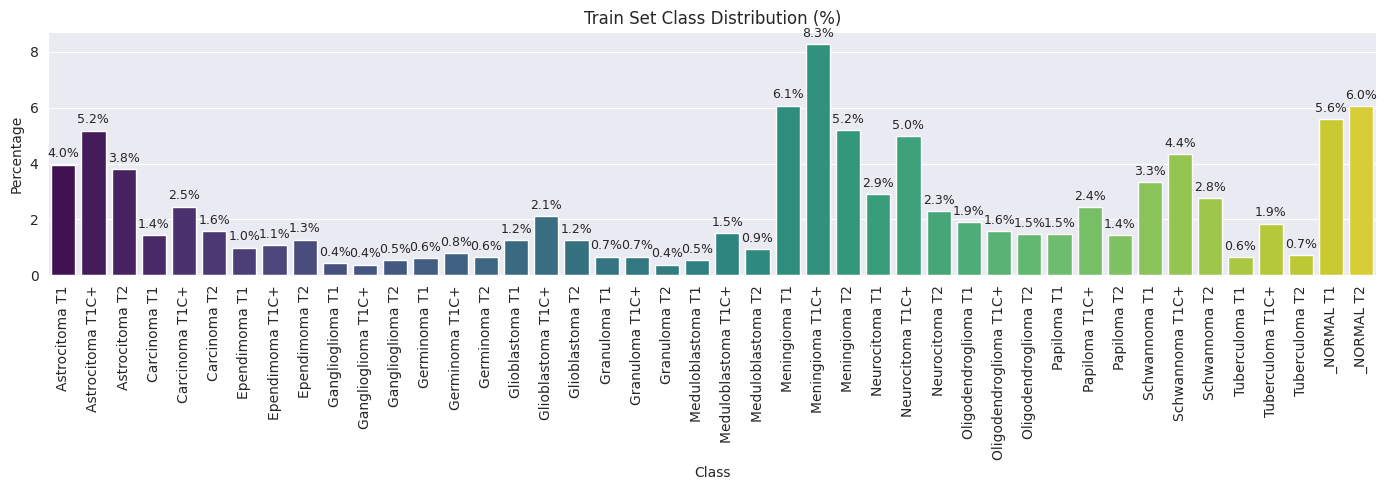

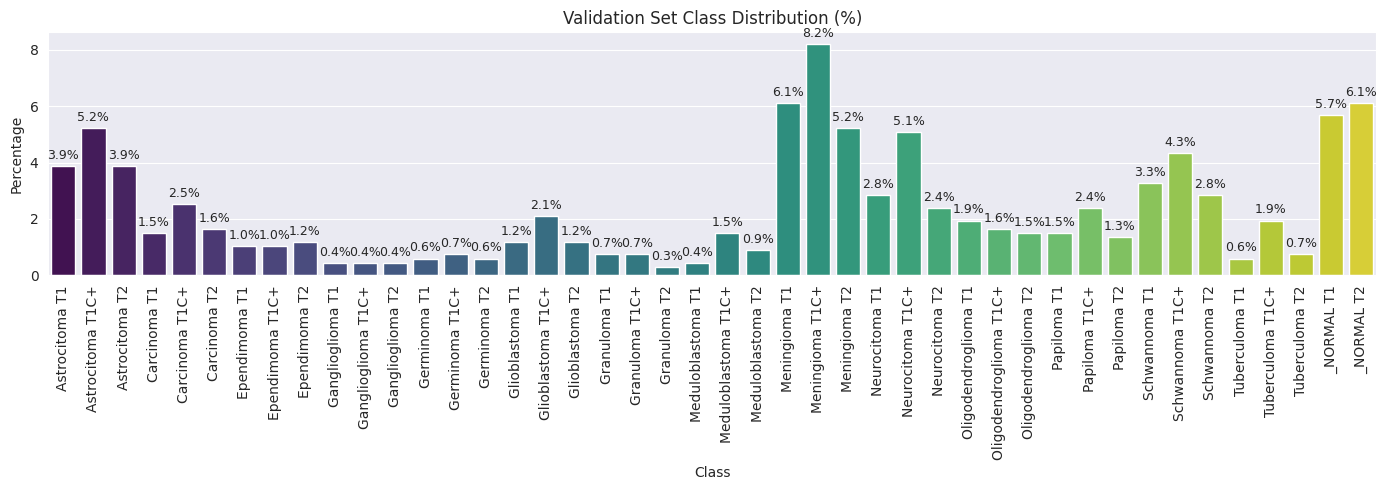

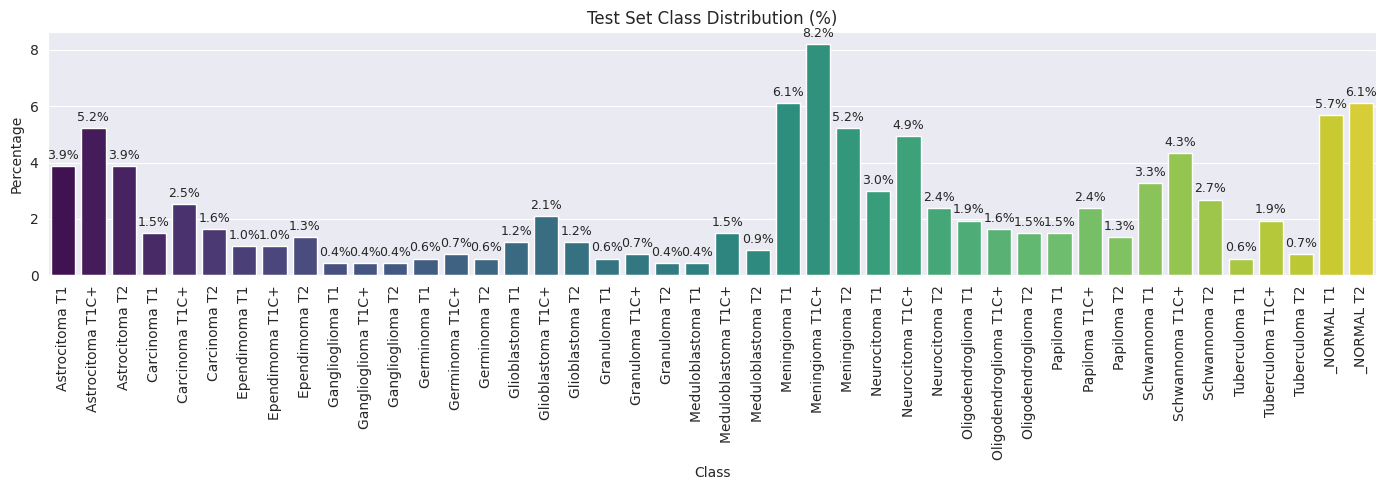

In [23]:
# Analyze Data
analyze_data_split(y_train, y_val, y_test, encoded_labels, class_names)

In [24]:
# Building Transfer Learning Model
model, base_model = build_transfer_model((224,224,3),44,pretrained_model=selected_model[1])
# Phase 1: Train with frozen base model
LR_BASE = 0.02
history1 = compile_and_train_model(model,  train_batches=train_ds, val_batches=val_ds, epochs=EPOCHS, lr=LR_BASE)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Total layers in model: 8
Base model trainable: True
Trainable weights: 247
Non-trainable weights: 118

--- Phase 1: Training with frozen base model ---
Using learning rate: 0.02


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 44)             │        11,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,717,820 (25.63 MB)

 Trainable params: 6,657,212 (25.40 MB)

 Non-trainable params: 60,608 (236.75 KB)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 153s 898ms/step - accuracy: 0.1319 - loss: 11.4342 - val_accuracy: 0.4866 - val_loss: 6.7978
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 59s 427ms/step - accuracy: 0.5204 - loss: 5.9493 - val_accuracy: 0.5731 - val_loss: 4.2099
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 428ms/step - accuracy: 0.6447 - loss: 3.5889 - val_accuracy: 0.6373 - val_loss: 2.8906
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 428ms/step - accuracy: 0.7199 - loss: 2.4007 - val_accuracy: 0.6896 - val_loss: 2.1367
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 432ms/step - accuracy: 0.7496 - loss: 1.7909 - val_accuracy: 0.7642 - val_loss: 1.5856
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 440ms/step - accuracy: 0.8037 - loss: 1.4152 - val_accuracy: 0.7985 - val_loss: 1.4318
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step - accuracy: 0.8292 - loss: 1.1147 - val_accuracy: 0.8060 - val_loss: 1.2113
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 437ms/step - accuracy: 0.8621 - loss: 0.9861 


--- Evaluating model on test set ---
Test Loss: 0.5082
Test Accuracy: 92.99%
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 352ms/step

Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1       1.00      0.92      0.96        26
      Astrocitoma T1C+       1.00      0.91      0.96        35
        Astrocitoma T2       0.92      0.88      0.90        26
          Carcinoma T1       1.00      0.90      0.95        10
        Carcinoma T1C+       1.00      1.00      1.00        17
          Carcinoma T2       1.00      0.82      0.90        11
         Ependimoma T1       0.86      0.86      0.86         7
       Ependimoma T1C+       1.00      0.86      0.92         7
         Ependimoma T2       1.00      1.00      1.00         9
      Ganglioglioma T1       1.00      0.33      0.50         3
    Ganglioglioma T1C+       1.00      1.00      1.00         3
      Ganglioglioma T2       0.00      0.00      0.00         3
          Germinoma T1 

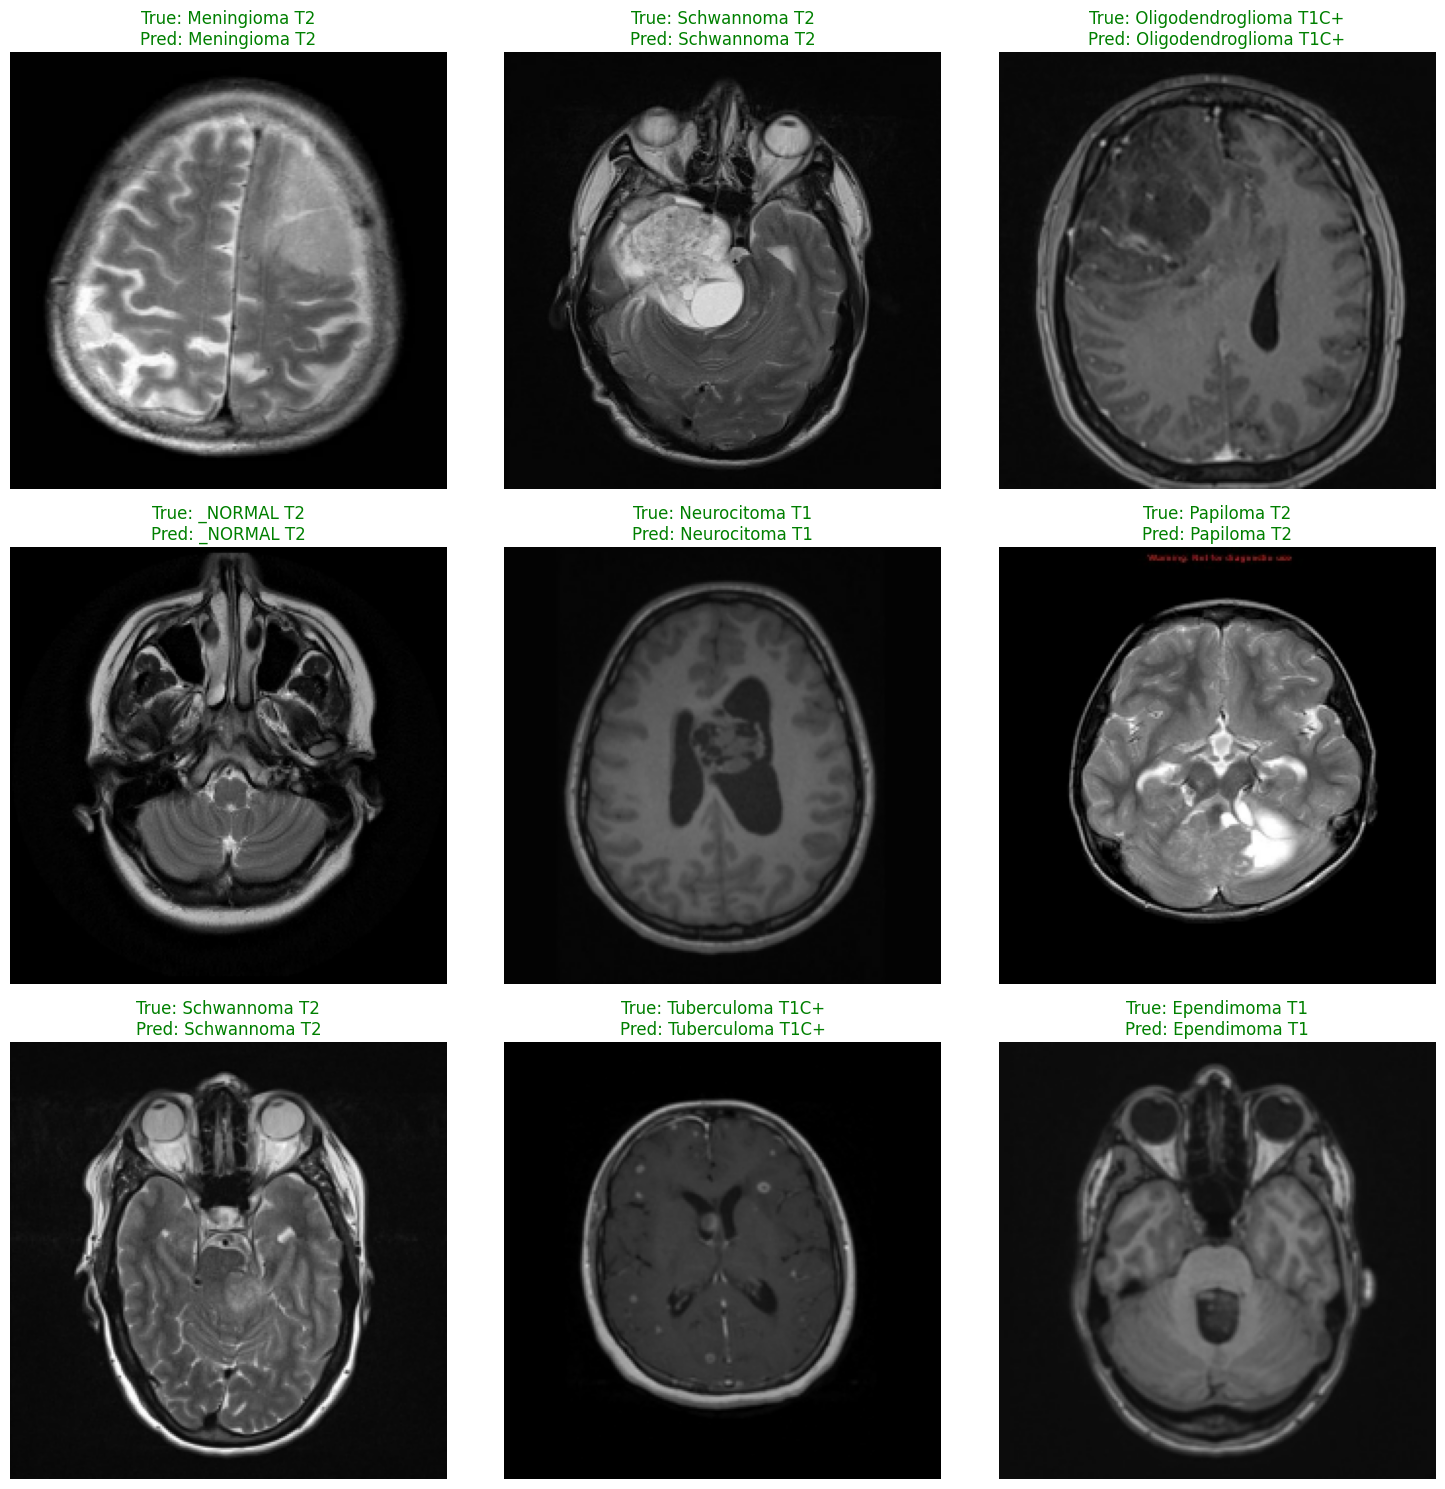

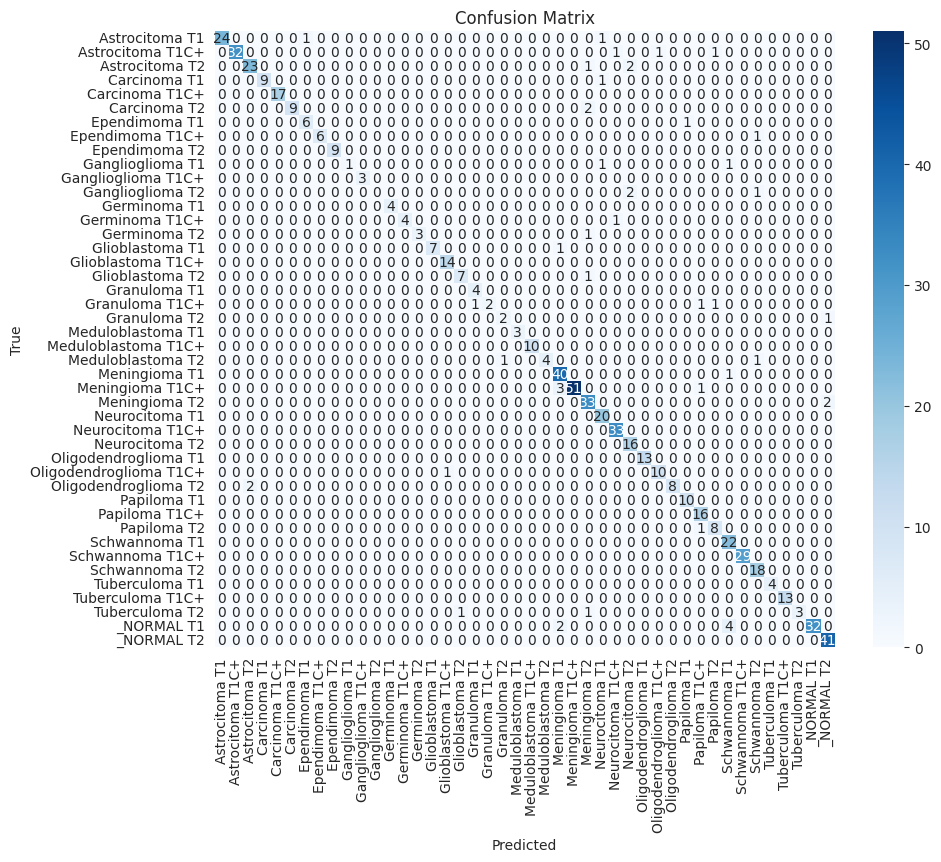

(0.5081617832183838,
 0.9298507571220398,
 '                        precision    recall  f1-score   support\n\n        Astrocitoma T1       1.00      0.92      0.96        26\n      Astrocitoma T1C+       1.00      0.91      0.96        35\n        Astrocitoma T2       0.92      0.88      0.90        26\n          Carcinoma T1       1.00      0.90      0.95        10\n        Carcinoma T1C+       1.00      1.00      1.00        17\n          Carcinoma T2       1.00      0.82      0.90        11\n         Ependimoma T1       0.86      0.86      0.86         7\n       Ependimoma T1C+       1.00      0.86      0.92         7\n         Ependimoma T2       1.00      1.00      1.00         9\n      Ganglioglioma T1       1.00      0.33      0.50         3\n    Ganglioglioma T1C+       1.00      1.00      1.00         3\n      Ganglioglioma T2       0.00      0.00      0.00         3\n          Germinoma T1       1.00      1.00      1.00         4\n        Germinoma T1C+       1.00      0.80 

In [26]:
# Evaluate on Frozen Base Model
evaluate_model(model,test_ds,
          class_names,model_key)

In [29]:
# Phase 2: Train with Fine-Tuned base model
# Reset Model
model, base_model = build_transfer_model((224,224,3),44,pretrained_model=selected_model[1])

# Start Training
history2 = fine_tune_model_by_layers(model,base_model, train_batches=train_ds, val_batches=val_ds, unfreeze_from_layer=LAYER_INDEX, lr=LR, epochs=EPOCHS)

Total layers in model: 8
Base model trainable: True
Trainable weights: 247
Non-trainable weights: 118

--- Phase 2: Fine-tuning from layer 100 ---

 Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 44)             │        11,308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,717,820 (25.63 MB)

 Trainable params: 5,954,156 (22.71 MB)

 Non-trainable params: 763,664 (2.91 MB)


--- Base Model Layers Summary ---
Total layers in base_model       : 270
Trainable layers in base_model   : 170
Non-trainable layers in base_model: 100

---  Parameters Summary ---
Trainable parameters: 5,954,156
Non-trainable parameters: 763,664
Total parameters: 6,717,820
Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 135s 786ms/step - accuracy: 0.2448 - loss: 8.0280 - val_accuracy: 0.4746 - val_loss: 3.0248
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 83s 451ms/step - accuracy: 0.5370 - loss: 2.5996 - val_accuracy: 0.5851 - val_loss: 2.2335
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 427ms/step - accuracy: 0.6447 - loss: 1.9844 - val_accuracy: 0.6627 - val_loss: 1.7156
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 438ms/step - accuracy: 0.6612 - loss: 1.7370 - val_accuracy: 0.6970 - val_loss: 1.7173
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 81s 424ms/step - accuracy: 0.7252 - loss: 1.4464 - val_accuracy: 0.7134 - val_loss: 1.4454
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 431ms/step - accuracy: 0.7641 


--- Evaluating model on test set ---
Test Loss: 0.4548
Test Accuracy: 93.73%
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 460ms/step

Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1       0.96      0.92      0.94        26
      Astrocitoma T1C+       0.94      0.86      0.90        35
        Astrocitoma T2       0.92      0.92      0.92        26
          Carcinoma T1       1.00      1.00      1.00        10
        Carcinoma T1C+       1.00      1.00      1.00        17
          Carcinoma T2       1.00      0.73      0.84        11
         Ependimoma T1       1.00      0.71      0.83         7
       Ependimoma T1C+       0.88      1.00      0.93         7
         Ependimoma T2       1.00      1.00      1.00         9
      Ganglioglioma T1       1.00      1.00      1.00         3
    Ganglioglioma T1C+       1.00      0.67      0.80         3
      Ganglioglioma T2       0.75      1.00      0.86         3
          Germinoma T1 

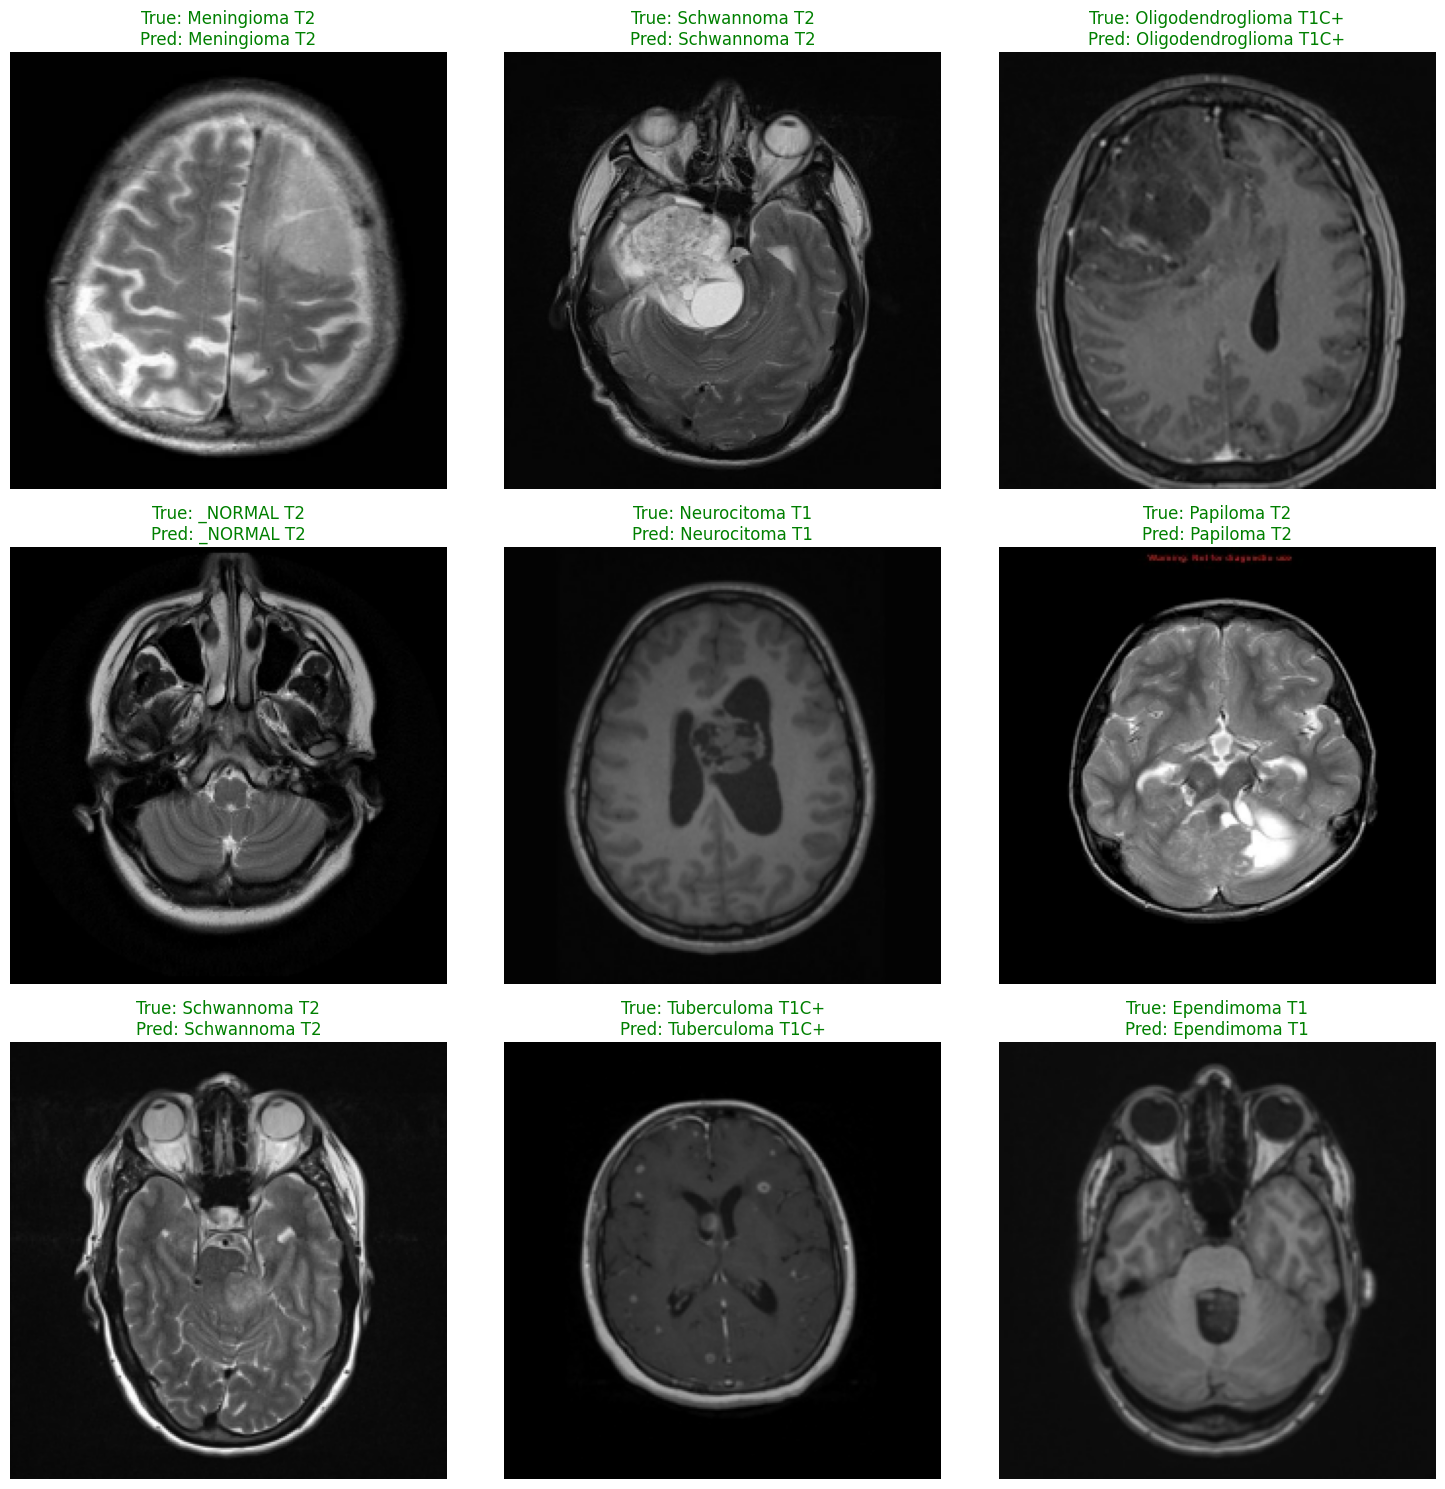

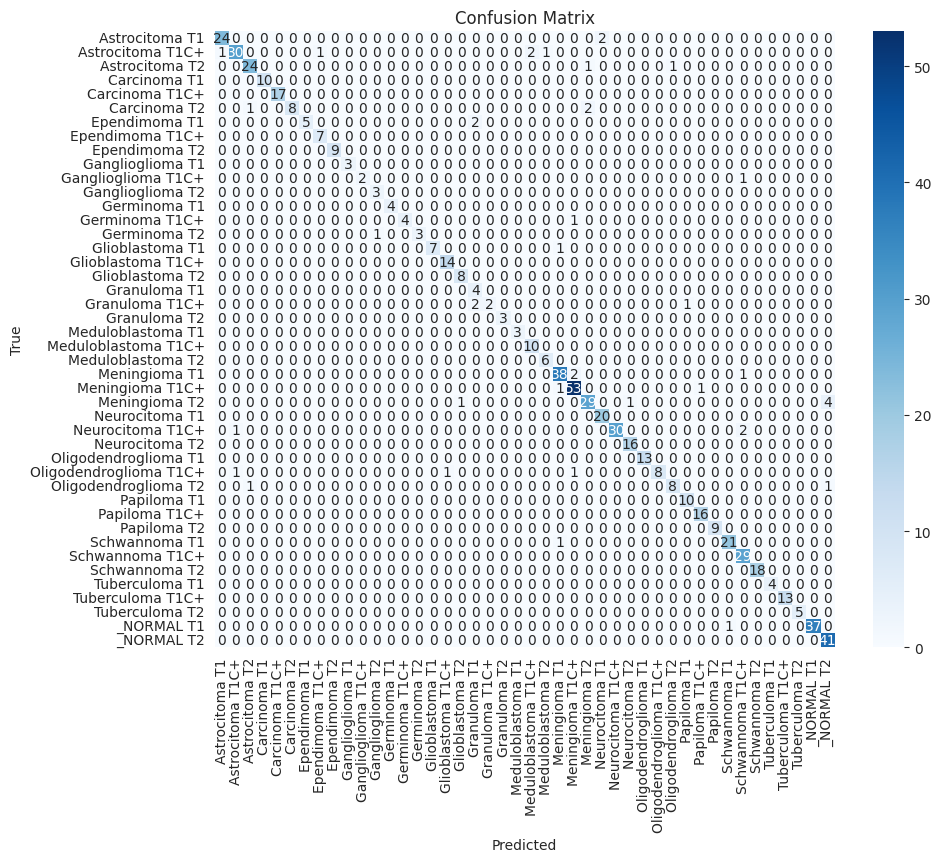

(0.4547579288482666,
 0.937313437461853,
 '                        precision    recall  f1-score   support\n\n        Astrocitoma T1       0.96      0.92      0.94        26\n      Astrocitoma T1C+       0.94      0.86      0.90        35\n        Astrocitoma T2       0.92      0.92      0.92        26\n          Carcinoma T1       1.00      1.00      1.00        10\n        Carcinoma T1C+       1.00      1.00      1.00        17\n          Carcinoma T2       1.00      0.73      0.84        11\n         Ependimoma T1       1.00      0.71      0.83         7\n       Ependimoma T1C+       0.88      1.00      0.93         7\n         Ependimoma T2       1.00      1.00      1.00         9\n      Ganglioglioma T1       1.00      1.00      1.00         3\n    Ganglioglioma T1C+       1.00      0.67      0.80         3\n      Ganglioglioma T2       0.75      1.00      0.86         3\n          Germinoma T1       1.00      1.00      1.00         4\n        Germinoma T1C+       1.00      0.80  

In [30]:
# Evaluate Fine-Tuned Model (Phase 2)
evaluate_model(model,test_ds,
          class_names,model_key)

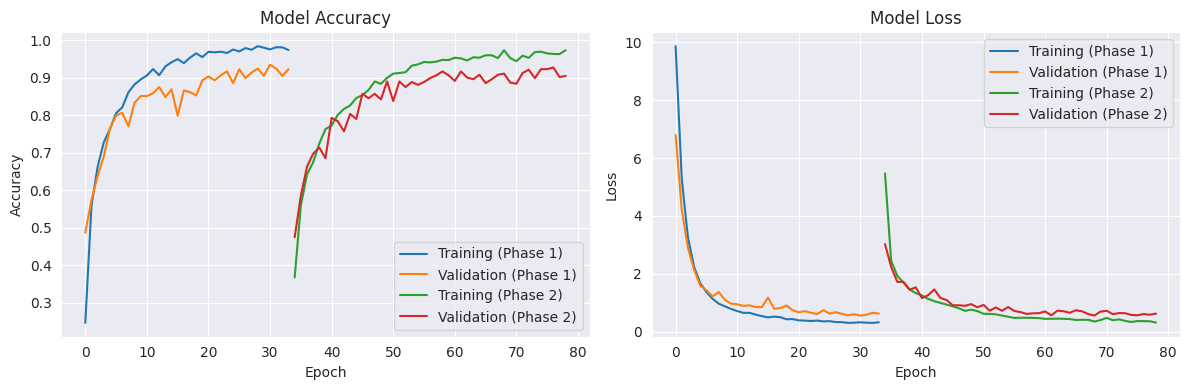

In [31]:
# Plot Learning Curve
plot_learning_curves(history1,history2)